In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load movie metadata
movies = pd.read_csv("../../data/clean/movie_metadata_cleaned.csv")

# Load character metadata
characters = pd.read_csv("../../data/clean/character_metadata_cleaned.csv")

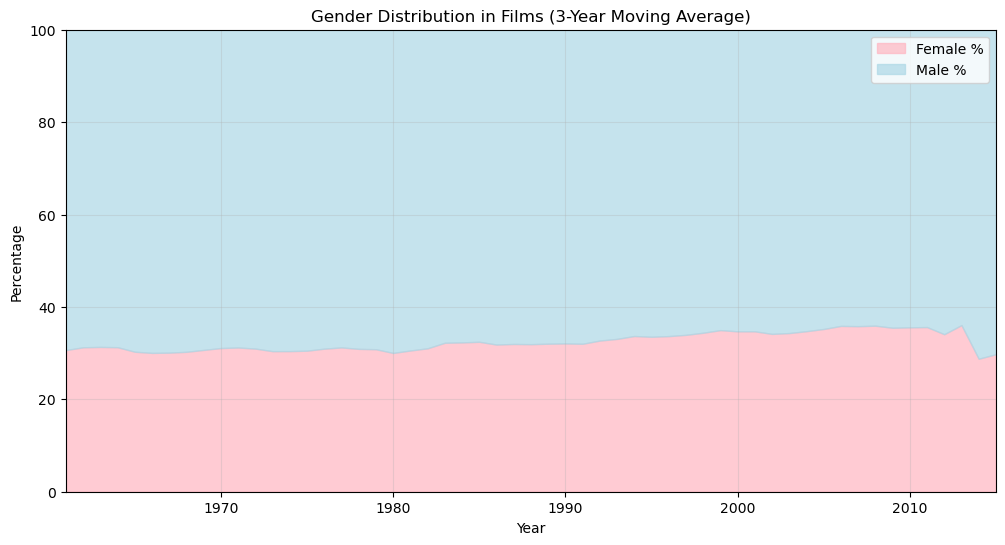

In [19]:
# Filter for movies after 1960 and valid gender entries
df = characters[characters['Actor gender'].notna()]
movies_filtered = movies[movies['Release date'] >= 1960]
merged_df = df.merge(movies_filtered, on=['Wikipedia movie ID', 'Freebase movie ID', 'Release date'])

# Calculate yearly gender distribution
yearly_gender = merged_df.groupby(['Release date', 'Actor gender']).size().unstack(fill_value=0)
total = yearly_gender.sum(axis=1)
gender_percentages = (yearly_gender.div(total, axis=0) * 100)

# Calculate 3-year moving average
ma_window = 3
gender_ma = gender_percentages.rolling(window=ma_window, center=True).mean()

plt.figure(figsize=(12, 6))

# Plot female percentage from 0
plt.fill_between(gender_ma.index, 0, gender_ma['F'], 
                 color='lightpink', alpha=0.7, label='Female %')

# Plot male percentage starting from female percentage
plt.fill_between(gender_ma.index, gender_ma['F'], 100, 
                 color='lightblue', alpha=0.7, label='Male %')

plt.title('Gender Distribution in Films (3-Year Moving Average)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.margins(x=0)
plt.show()

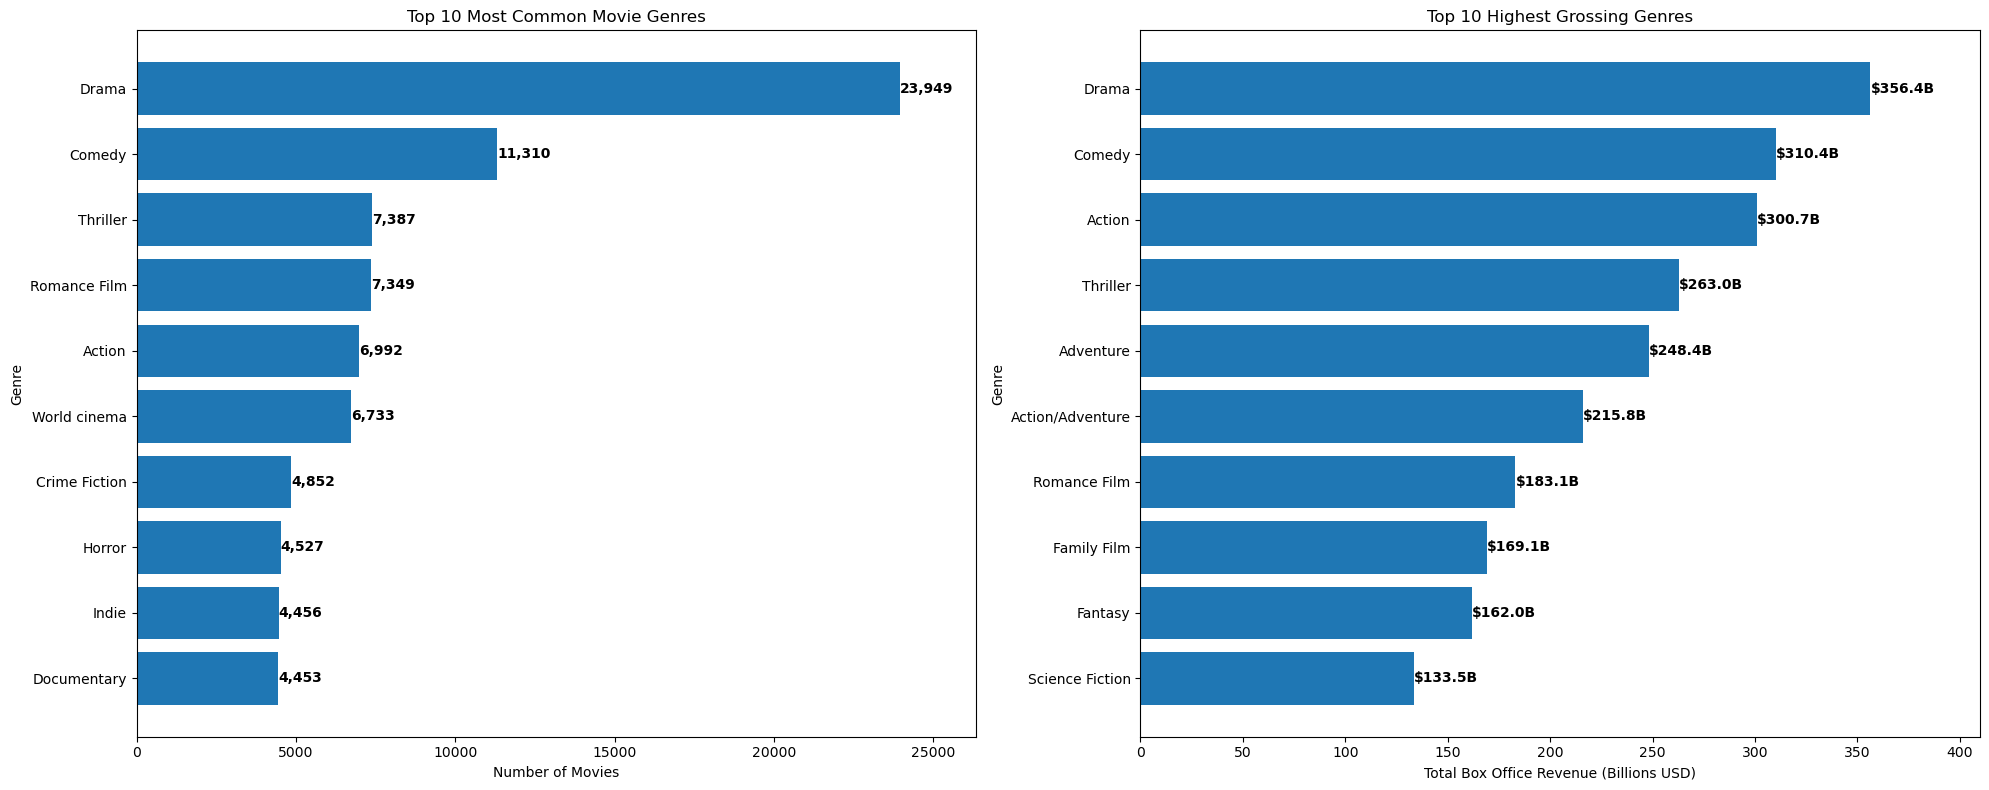

In [18]:
# Data preprocessing
movies_filtered = movies[movies['Release date'] >= 1960].copy()
movies_filtered['Box office revenue'] = pd.to_numeric(movies_filtered['Box office revenue'], errors='coerce')
movies_filtered['Genres'] = movies_filtered['Genres'].apply(eval)

# Create genre revenue dictionary
genre_revenue = {}
for _, movie in movies_filtered.iterrows():
    if pd.notna(movie['Box office revenue']):
        for genre in movie['Genres']:
            if genre in genre_revenue:
                genre_revenue[genre] += movie['Box office revenue']
            else:
                genre_revenue[genre] = movie['Box office revenue']

# Convert to DataFrame and get top 10
genre_revenue_df = pd.DataFrame.from_dict(genre_revenue, orient='index', columns=['revenue'])
top_10_revenue = genre_revenue_df.nlargest(10, 'revenue')

# Count genre occurrences
genres_df = movies_filtered.explode('Genres')
genre_counts = genres_df['Genres'].value_counts().head(10)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot genre counts on left
bars1 = ax1.barh(genre_counts.index, genre_counts.values)
ax1.set_xlabel('Number of Movies')
ax1.set_ylabel('Genre')
ax1.set_title('Top 10 Most Common Movie Genres')

# Add value labels with padding for left plot
max_count = genre_counts.values.max()
ax1.set_xlim(0, max_count * 1.10)
for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', 
             ha='left', va='center', fontweight='bold')

# Plot genre revenue on right
bars2 = ax2.barh(top_10_revenue.index, top_10_revenue['revenue'] / 1e9)
ax2.set_xlabel('Total Box Office Revenue (Billions USD)')
ax2.set_ylabel('Genre')
ax2.set_title('Top 10 Highest Grossing Genres')

# Add value labels with padding for right plot
max_revenue = (top_10_revenue['revenue'] / 1e9).max()
ax2.set_xlim(0, max_revenue * 1.15)  # Add 15% padding
for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'${width:.1f}B', 
             ha='left', va='center', fontweight='bold')

# Invert y-axis to show highest at top
ax1.invert_yaxis()
ax2.invert_yaxis()

plt.tight_layout()
plt.show()